# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import json
import os
import random
from collections import namedtuple
from PIL import Image

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

The following articles were referenced in developing the code below:

- Pipeline suggestions [article](https://medium.com/@14prakash/almost-any-image-classification-problem-using-pytorch-i-am-in-love-with-pytorch-26c7aa979ec4) on Medium

In [2]:
# Create data details
data_dir = 'flowers' # Main image folder directory
input_shape = 224 # Image size in pixels
scale = 255 # Image reduction scale
Data = namedtuple('Data', 'train valid test')
Details = namedtuple('Details', 'batch_size shuffle_setting')
set_details = Data(Details(64, True), Details(32, False), Details(32, False))
mean = [0.485, 0.456, 0.406] # Color normalization mean
std = [0.229, 0.224, 0.225] # Color normalization std

In [3]:
# Create transforms for the training, validation, and testing sets
data_transforms = Data(
    transforms.Compose([transforms.RandomResizedCrop(input_shape),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.RandomRotation(degrees=90),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)]),
    transforms.Compose([transforms.Resize(scale),
                        transforms.CenterCrop(input_shape),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)]),
    transforms.Compose([transforms.Resize(scale),
                        transforms.CenterCrop(input_shape),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)]))

In [4]:
# Load datasets
image_datasets = [datasets.ImageFolder(os.path.join(data_dir, data_set),
                                       getattr(data_transforms, data_set)) \
                  for data_set in data_transforms._fields]
image_datasets = Data(image_datasets[0], image_datasets[1], image_datasets[2])

# Check construction
for dataset, image_dataset in zip(image_datasets._fields, image_datasets):
    print(dataset + ':', '\n', image_dataset, '\n')

train: 
 Dataset ImageFolder
    Number of datapoints: 6552
    Root Location: flowers\train
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             RandomVerticalFlip(p=0.5)
                             RandomRotation(degrees=(-90, 90), resample=False, expand=False)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None 

valid: 
 Dataset ImageFolder
    Number of datapoints: 818
    Root Location: flowers\valid
    Transforms (if any): Compose(
                             Resize(size=255, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                          

In [5]:
# Create dataloaders
data_loaders = [torch.utils.data.DataLoader(image_dataset, 
                                            batch_size=set_detail.batch_size,
                                            shuffle=set_detail.shuffle_setting) \
                for data_set, image_dataset, set_detail \
                in zip(image_datasets._fields, image_datasets, set_details)]
data_loaders = Data(data_loaders[0], data_loaders[1], data_loaders[2])

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
# Load flower names
with open('cat_to_name.json', 'r') as f:
    flower_names = json.load(f)
    
# Examine contents of flower_names
for i, key in enumerate(flower_names.keys()):
    print(key, ':', flower_names[key])
    if i == 5:
        break

21 : fire lily
3 : canterbury bells
45 : bolero deep blue
1 : pink primrose
34 : mexican aster
27 : prince of wales feathers


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [7]:
# Load pretrained model
model = models.vgg19_bn(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [8]:
# Define network
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: (int) size of the input
            output_size: (int) size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: (float) between 0 and 1, dropout probability
        '''
        super().__init__()
        # Add the first layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, 
                                                      hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([
            nn.Linear(h_input, h_output) for h_input, h_output in layer_sizes])
        
        # Add output layer
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        # Include dropout
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        # Forward through each hidden layer with ReLU and dropout
        for layer in self.hidden_layers:
            x = F.relu(layer(x)) # Apply activation
            x = self.dropout(x) # Apply dropout
        
        # Pass through output layer
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [10]:
# Set up network
# Freeze parameters to avoid training
for param in model.parameters():
    param.requires_grad = False

# Create classifier, define criterion and optimizer
classifier = Network(input_size=25088, 
                     output_size=102, 
                     hidden_layers=[516, 256])

# Replace the vgg classifier with new classifier
model.classifier = classifier

# Set criterion and optimizier
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Set number of epochs
epochs = 10

In [13]:
# Implement a function to update the classifier
def update_classifier(model, hidden_layers):
    # Freeze parameters to avoid training
    for param in model.parameters():
        param.requires_grad = False
    
    # Get input_size and output sizes
    input_size = model.classifier[0].in_features
    output_size = 102

    # Create classifier and replace pre-trained classifier
    classifier = Network(input_size=input_size, output_size=output_size, 
                         hidden_layers=hidden_layers)
    model.classifier = classifier

In [14]:
# Test using variable with . notation
test = getattr(optim, 'SGD')(model.classifier.parameters(), lr=0.001)
test

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [15]:
# Implement a function to set hyperparameters
def set_hyperparams(model, randomize=True, optimizer_name='Adam', 
                    learnrate=0.0001, epochs=15, gpu=True):
    # Move model to GPU if selected and available
    device = torch.device("cpu")
    if gpu:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # List of optimizer names
    optimizer_names = ['Adam', 'Adagrad', 'RMSprop']

    # Create randomization of parameters
    if randomize:
        learnrate = random.uniform(5e-5, 1e-3)
        optimizer = getattr(optim, random.choice(optimizer_names))(
            model.classifier.parameters(), lr=learnrate)
        epochs=random.randint(10, 36) # Limited to 35 max to limit runtime
    else:
        optimizer = getattr(optim, optimizer_name)
        optimizer = optimizer(model.classifier.parameters(), lr=learnrate)
    
    return optimizer, epochs

In [16]:
# Implement a function for the validation pass of test data
def validation(model, testloader, criterion, gpu):
    test_loss = 0
    accuracy = 0
    
    device = torch.device("cpu")
    if gpu:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        
        # Convert back to softmax distribution
        ps = torch.exp(output)
        # Compare highest prob predicted class ps.max(dim=1)[1] with labels
        equality = (labels.data == ps.max(dim=1)[1])
        # Convert to cpu and type FloatTensor for mean
        equality.cpu()
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [18]:
# Test GPU availability
torch.cuda.is_available()

True

In [21]:
def model_train(model, trainloader, validloader, 
                optimizer, epochs=10, gpu=True):
    # Create variables for printing
    steps = 0
    running_loss = 0
    print_every = 20 # Set to 2minimize difference in loss collected for metrics
    
    # Conditional GPU activation
    device = torch.device("cpu")
    if gpu:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Using GPU?", torch.cuda.is_available())
    model.to(device)
    
    # Set criterion
    criterion = nn.NLLLoss()

    # Display model hyperparameters
    learnrate = optimizer.state_dict()['param_groups'][0]['lr']
    optimizer_name = optimizer.__class__.__name__
    print('---Model Hyperparameters---\n'
          'Optimizer: {}  Epochs: {}  Learning Rate: {}\n'.format(
              optimizer_name, epochs, learnrate))

    # Run training
    for e in range(epochs):
        model.train() # Set to training mode 'just in case'
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            steps += 1
            
            # Zero out gradients for each epoch
            optimizer.zero_grad()
            
            output = model.forward(images) # Feedforward through model
            loss = criterion(output, labels) # Calculate loss
            loss.backward() # Feed loss back through model
            optimizer.step() # Adjust weights
            
            running_loss += loss.item()
            
            # Print testing details
            if steps % print_every == 0:
                # Put in eval mode
                model.eval()
                model.to(device)
                
                # Turn off gradients
                with torch.no_grad():
                    test_loss, accuracy = validation(model, validloader, 
                                                     criterion, gpu)
                
                train_loss = running_loss/print_every
                valid_loss = test_loss/len(validloader)
                valid_accuracy = accuracy/len(validloader)
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_loss),
                  "Valid. Loss: {:.3f}.. ".format(valid_loss),
                  "Valid. Accuracy: {:.3f}".format(valid_accuracy))
            
            # Reset running_loss
            running_loss = 0
            
            # Make sure training is back on
            model.train()
    
    # Return last run of metrics for later use
    return train_loss, valid_loss, valid_accuracy.item()

In [22]:
train_loss, valid_loss, valid_accuracy = model_train(
    model, data_loaders.train, data_loaders.valid, optimizer, epochs=1)

Using GPU? True
---Model Hyperparameters---
Optimizer: Adam  Epochs: 1  Learning Rate: 0.001

Epoch: 1/1..  Training Loss: 0.230..  Valid. Loss: 4.473..  Valid. Accuracy: 0.044
Epoch: 1/1..  Training Loss: 0.222..  Valid. Loss: 4.397..  Valid. Accuracy: 0.052
Epoch: 1/1..  Training Loss: 0.219..  Valid. Loss: 4.214..  Valid. Accuracy: 0.090
Epoch: 1/1..  Training Loss: 0.209..  Valid. Loss: 3.943..  Valid. Accuracy: 0.137
Epoch: 1/1..  Training Loss: 0.198..  Valid. Loss: 3.636..  Valid. Accuracy: 0.212


<a id='random-search'></a>
### Random Search
I wanted to conduct a random search of some of the hyperparameters and so I needed to determine how to save the the models as I went. So I jumped down to the <a href="save-model">Save the checkpoint</a> section and then came back here. 

In [48]:
# Implement basic random search tester function
def random_search(model, n_iter, trainloader, validloader, trainimages, 
                  save_location, gpu):
    # Count number of files in dir
    files_in_folder = len([name for name in os.listdir(save_location) \
                           if os.path.isfile(name)])

    # Run n_iter number of tests
    for i in range(n_iter):
        # Manage 'GPU in use' RuntimeErrors
        try:
            print('\nTest No.', i + files_in_folder)
            # Randomize hyperparams
            optimizer, epochs = set_hyperparams(model, gpu=gpu)
            
            # Train model
            train_loss, valid_loss, valid_accuracy = model_train(
                model, trainloader, validloader, optimizer, epochs, gpu)
            # Save model
            save_model(model, optimizer, epochs, trainimages,
                       train_loss, valid_loss, valid_accuracy, save_location)
        
        except RuntimeError as e:
            print(e, '\n Moving to next model.')
            continue

After a couple of runs it became clear that a learning rate that was too high (above 0.001) was completely ineffective. I also noticed that too low was not helpful. I adjusted the potential range to 5e-5 to 1e-3. 

In addition, given that the goal was only 70% accuracy, I decided that given that some combinations were reaching over 80% at around 35 epochs, I would reduce the maximum number of epochs to 35 (from 50) to again reduce the run time. 

In [38]:
random_search(model, n_iter=5, trainloader=data_loaders.train, 
              validloader=data_loaders.valid, trainimages=image_datasets.train,
              save_location='training_models', gpu=True)


Test No. 1
---Model Hyperparameters---
Optimizer: Adagrad  Epochs: 31  Learning Rate: 0.0008356848240616492

Using GPU? True
Epoch: 1/31..  Training Loss: 0.230..  Valid. Loss: 4.486..  Valid. Accuracy: 0.052
Epoch: 1/31..  Training Loss: 0.225..  Valid. Loss: 4.420..  Valid. Accuracy: 0.070
Epoch: 1/31..  Training Loss: 0.228..  Valid. Loss: 4.352..  Valid. Accuracy: 0.052
Epoch: 1/31..  Training Loss: 0.215..  Valid. Loss: 4.269..  Valid. Accuracy: 0.106
Epoch: 1/31..  Training Loss: 0.218..  Valid. Loss: 4.195..  Valid. Accuracy: 0.109
Epoch: 2/31..  Training Loss: 0.212..  Valid. Loss: 4.124..  Valid. Accuracy: 0.126
Epoch: 2/31..  Training Loss: 0.207..  Valid. Loss: 4.066..  Valid. Accuracy: 0.118
Epoch: 2/31..  Training Loss: 0.214..  Valid. Loss: 4.017..  Valid. Accuracy: 0.126
Epoch: 2/31..  Training Loss: 0.211..  Valid. Loss: 3.965..  Valid. Accuracy: 0.125
Epoch: 2/31..  Training Loss: 0.205..  Valid. Loss: 3.904..  Valid. Accuracy: 0.144
Epoch: 3/31..  Training Loss: 0.20

Epoch: 19/31..  Training Loss: 0.140..  Valid. Loss: 2.009..  Valid. Accuracy: 0.545
Epoch: 20/31..  Training Loss: 0.135..  Valid. Loss: 1.988..  Valid. Accuracy: 0.553
Epoch: 20/31..  Training Loss: 0.123..  Valid. Loss: 1.968..  Valid. Accuracy: 0.545
Epoch: 20/31..  Training Loss: 0.148..  Valid. Loss: 1.981..  Valid. Accuracy: 0.551
Epoch: 20/31..  Training Loss: 0.126..  Valid. Loss: 1.972..  Valid. Accuracy: 0.555
Epoch: 20/31..  Training Loss: 0.136..  Valid. Loss: 1.945..  Valid. Accuracy: 0.547
Epoch: 20/31..  Training Loss: 0.121..  Valid. Loss: 1.925..  Valid. Accuracy: 0.567
Epoch: 21/31..  Training Loss: 0.125..  Valid. Loss: 1.947..  Valid. Accuracy: 0.557
Epoch: 21/31..  Training Loss: 0.132..  Valid. Loss: 1.928..  Valid. Accuracy: 0.558
Epoch: 21/31..  Training Loss: 0.143..  Valid. Loss: 1.928..  Valid. Accuracy: 0.561
Epoch: 21/31..  Training Loss: 0.142..  Valid. Loss: 1.909..  Valid. Accuracy: 0.556
Epoch: 21/31..  Training Loss: 0.138..  Valid. Loss: 1.906..  Val

Epoch: 7/35..  Training Loss: 0.116..  Valid. Loss: 1.089..  Valid. Accuracy: 0.711
Epoch: 7/35..  Training Loss: 0.089..  Valid. Loss: 1.070..  Valid. Accuracy: 0.700
Epoch: 7/35..  Training Loss: 0.093..  Valid. Loss: 1.016..  Valid. Accuracy: 0.732
Epoch: 8/35..  Training Loss: 0.096..  Valid. Loss: 1.047..  Valid. Accuracy: 0.729
Epoch: 8/35..  Training Loss: 0.093..  Valid. Loss: 1.028..  Valid. Accuracy: 0.742
Epoch: 8/35..  Training Loss: 0.085..  Valid. Loss: 0.975..  Valid. Accuracy: 0.753
Epoch: 8/35..  Training Loss: 0.078..  Valid. Loss: 0.944..  Valid. Accuracy: 0.750
Epoch: 8/35..  Training Loss: 0.084..  Valid. Loss: 0.966..  Valid. Accuracy: 0.741
Epoch: 9/35..  Training Loss: 0.093..  Valid. Loss: 0.952..  Valid. Accuracy: 0.747
Epoch: 9/35..  Training Loss: 0.079..  Valid. Loss: 0.922..  Valid. Accuracy: 0.759
Epoch: 9/35..  Training Loss: 0.099..  Valid. Loss: 0.950..  Valid. Accuracy: 0.744
Epoch: 9/35..  Training Loss: 0.077..  Valid. Loss: 0.922..  Valid. Accuracy

Epoch: 26/35..  Training Loss: 0.065..  Valid. Loss: 0.528..  Valid. Accuracy: 0.870
Epoch: 26/35..  Training Loss: 0.077..  Valid. Loss: 0.560..  Valid. Accuracy: 0.859
Epoch: 26/35..  Training Loss: 0.065..  Valid. Loss: 0.519..  Valid. Accuracy: 0.867
Epoch: 27/35..  Training Loss: 0.060..  Valid. Loss: 0.535..  Valid. Accuracy: 0.855
Epoch: 27/35..  Training Loss: 0.066..  Valid. Loss: 0.535..  Valid. Accuracy: 0.860
Epoch: 27/35..  Training Loss: 0.074..  Valid. Loss: 0.531..  Valid. Accuracy: 0.865
Epoch: 27/35..  Training Loss: 0.071..  Valid. Loss: 0.528..  Valid. Accuracy: 0.869
Epoch: 27/35..  Training Loss: 0.069..  Valid. Loss: 0.564..  Valid. Accuracy: 0.842
Epoch: 27/35..  Training Loss: 0.067..  Valid. Loss: 0.532..  Valid. Accuracy: 0.857
Epoch: 28/35..  Training Loss: 0.067..  Valid. Loss: 0.546..  Valid. Accuracy: 0.857
Epoch: 28/35..  Training Loss: 0.067..  Valid. Loss: 0.568..  Valid. Accuracy: 0.853
Epoch: 28/35..  Training Loss: 0.062..  Valid. Loss: 0.543..  Val

Epoch: 10/21..  Training Loss: 0.113..  Valid. Loss: 1.172..  Valid. Accuracy: 0.704
Epoch: 10/21..  Training Loss: 0.106..  Valid. Loss: 1.163..  Valid. Accuracy: 0.721
Epoch: 10/21..  Training Loss: 0.079..  Valid. Loss: 1.176..  Valid. Accuracy: 0.713
Epoch: 10/21..  Training Loss: 0.101..  Valid. Loss: 1.118..  Valid. Accuracy: 0.711
Epoch: 10/21..  Training Loss: 0.110..  Valid. Loss: 1.122..  Valid. Accuracy: 0.721
Epoch: 11/21..  Training Loss: 0.086..  Valid. Loss: 1.117..  Valid. Accuracy: 0.712
Epoch: 11/21..  Training Loss: 0.101..  Valid. Loss: 1.073..  Valid. Accuracy: 0.725
Epoch: 11/21..  Training Loss: 0.087..  Valid. Loss: 1.052..  Valid. Accuracy: 0.717
Epoch: 11/21..  Training Loss: 0.095..  Valid. Loss: 1.046..  Valid. Accuracy: 0.730
Epoch: 11/21..  Training Loss: 0.094..  Valid. Loss: 1.016..  Valid. Accuracy: 0.749
Epoch: 12/21..  Training Loss: 0.093..  Valid. Loss: 0.997..  Valid. Accuracy: 0.743
Epoch: 12/21..  Training Loss: 0.088..  Valid. Loss: 0.999..  Val

Epoch: 7/26..  Training Loss: 0.185..  Valid. Loss: 3.109..  Valid. Accuracy: 0.320
Epoch: 7/26..  Training Loss: 0.186..  Valid. Loss: 3.091..  Valid. Accuracy: 0.323
Epoch: 8/26..  Training Loss: 0.173..  Valid. Loss: 3.077..  Valid. Accuracy: 0.321
Epoch: 8/26..  Training Loss: 0.173..  Valid. Loss: 3.060..  Valid. Accuracy: 0.327
Epoch: 8/26..  Training Loss: 0.173..  Valid. Loss: 3.014..  Valid. Accuracy: 0.354
Epoch: 8/26..  Training Loss: 0.173..  Valid. Loss: 2.979..  Valid. Accuracy: 0.355
Epoch: 8/26..  Training Loss: 0.171..  Valid. Loss: 2.964..  Valid. Accuracy: 0.345
Epoch: 9/26..  Training Loss: 0.168..  Valid. Loss: 2.948..  Valid. Accuracy: 0.352
Epoch: 9/26..  Training Loss: 0.176..  Valid. Loss: 2.924..  Valid. Accuracy: 0.358
Epoch: 9/26..  Training Loss: 0.174..  Valid. Loss: 2.895..  Valid. Accuracy: 0.362
Epoch: 9/26..  Training Loss: 0.156..  Valid. Loss: 2.889..  Valid. Accuracy: 0.372
Epoch: 9/26..  Training Loss: 0.168..  Valid. Loss: 2.863..  Valid. Accuracy

Epoch: 26/26..  Training Loss: 0.129..  Valid. Loss: 1.867..  Valid. Accuracy: 0.571
Epoch: 26/26..  Training Loss: 0.135..  Valid. Loss: 1.892..  Valid. Accuracy: 0.555

Test No. 5
---Model Hyperparameters---
Optimizer: Adam  Epochs: 28  Learning Rate: 0.00030894607090386524

Using GPU? True
Epoch: 1/28..  Training Loss: 0.229..  Valid. Loss: 4.478..  Valid. Accuracy: 0.043
Epoch: 1/28..  Training Loss: 0.220..  Valid. Loss: 4.396..  Valid. Accuracy: 0.105
Epoch: 1/28..  Training Loss: 0.221..  Valid. Loss: 4.236..  Valid. Accuracy: 0.095
Epoch: 1/28..  Training Loss: 0.211..  Valid. Loss: 4.091..  Valid. Accuracy: 0.101
Epoch: 1/28..  Training Loss: 0.208..  Valid. Loss: 3.943..  Valid. Accuracy: 0.115
Epoch: 2/28..  Training Loss: 0.199..  Valid. Loss: 3.699..  Valid. Accuracy: 0.190
Epoch: 2/28..  Training Loss: 0.207..  Valid. Loss: 3.565..  Valid. Accuracy: 0.195
Epoch: 2/28..  Training Loss: 0.191..  Valid. Loss: 3.311..  Valid. Accuracy: 0.261
Epoch: 2/28..  Training Loss: 0.18

Epoch: 19/28..  Training Loss: 0.084..  Valid. Loss: 0.694..  Valid. Accuracy: 0.821
Epoch: 19/28..  Training Loss: 0.071..  Valid. Loss: 0.640..  Valid. Accuracy: 0.849
Epoch: 19/28..  Training Loss: 0.068..  Valid. Loss: 0.686..  Valid. Accuracy: 0.813
Epoch: 20/28..  Training Loss: 0.076..  Valid. Loss: 0.634..  Valid. Accuracy: 0.837
Epoch: 20/28..  Training Loss: 0.085..  Valid. Loss: 0.637..  Valid. Accuracy: 0.823
Epoch: 20/28..  Training Loss: 0.065..  Valid. Loss: 0.633..  Valid. Accuracy: 0.831
Epoch: 20/28..  Training Loss: 0.074..  Valid. Loss: 0.640..  Valid. Accuracy: 0.824
Epoch: 20/28..  Training Loss: 0.074..  Valid. Loss: 0.641..  Valid. Accuracy: 0.827
Epoch: 20/28..  Training Loss: 0.079..  Valid. Loss: 0.603..  Valid. Accuracy: 0.834
Epoch: 21/28..  Training Loss: 0.057..  Valid. Loss: 0.610..  Valid. Accuracy: 0.845
Epoch: 21/28..  Training Loss: 0.065..  Valid. Loss: 0.616..  Valid. Accuracy: 0.841
Epoch: 21/28..  Training Loss: 0.085..  Valid. Loss: 0.597..  Val

### Observations while Random Searching
**Test No. 1**
- Optimizer: Adam
- Epochs: 31
- LR: 0.0008355
- Initial learning was quite fast reached 70% in under 10 epochs
- Reached validation accuracy of 80% around 15 epochs but didn't really improve after that

**Test No. 2**
- Optimizer: RMSprop
- Epochs: 31
- LR: 0.007900
- Slower initial learning, reached 70% at 18 epochs
- Reached validation accuracy of 75% around 25 epochs with no meaningful improvement after this.

**Test No. 3**
- Optimizer: Adam
- Epochs: 16
- LR: 0.0008624
- Reached 70% in similar speed to Test 1 (around 7 epochs)
- Didn't quite reach 80%

**Test No. 4**
- Optimizer: RMSprop
- Epochs: 13
- LR: 0.0001179
- Reached 70% around 12 epochs (faster than RMS with higher learn rate)

**Test No. 5**
- Optimizer: Adagrad
- Epochs: 31
- LR: 0.00083568
- Took 16 epochs to get to 50%
- Didn't reach 70% by 31 epochs

**Test No. 6**
- Optimizer: Adam
- Epochs: 35
- LR: 0.0004413
- Reached 70% in 6 epochs
- Got up to around 88% accuracy but couldn't get any higher. Perhaps the learning rate is still too high at this point.

**Test No. 7**
- Optimizer: RSMprop
- Epochs: 21
- LR: 0.0002146
- Reached 70% at 9 epochs which is faster than any previous attempt. 
- Hit over 80% by the end, which hadn't occurred for a RSM model before, also seemed that it was continuing to learn at this time
- **This is the best RSMprop model available**

**Test No. 8**
- Optimizer: Adagrad
- Epochs: 26
- LR: 0.0006992
- Took 19 epochs to reach 50%
- I wonder if Adagrad would benefit from a higher learning rate?

**Test No. 9**
- Optimizer: Adam
- Epochs: 28
- LR: 0.0003089
- Reached 70% in 7/8 epochs
- Reached 85% around 22 epochs and did seem to still be learning at the end
- **This is the best Adam model available**

It's impressive what can come out of even a very simple random search. I'd like to see if more training on the best RMSprop and Adam models could improve their performance.

Given that the last model run will still be in the system, I can just run more training on that model.

In [50]:
optimizer = optim.Adam(model.classifier.parameters(), lr=0.00030894607090386524)
epochs = 10

In [51]:
train_loss, valid_loss, valid_accuracy = model_train(
    model, data_loaders.train, data_loaders.valid, optimizer, epochs)

Using GPU? True
Epoch: 1/10..  Training Loss: 0.064..  Valid. Loss: 0.530..  Valid. Accuracy: 0.851
Epoch: 1/10..  Training Loss: 0.072..  Valid. Loss: 0.532..  Valid. Accuracy: 0.855
Epoch: 1/10..  Training Loss: 0.049..  Valid. Loss: 0.519..  Valid. Accuracy: 0.858
Epoch: 1/10..  Training Loss: 0.075..  Valid. Loss: 0.531..  Valid. Accuracy: 0.852
Epoch: 1/10..  Training Loss: 0.053..  Valid. Loss: 0.521..  Valid. Accuracy: 0.858
Epoch: 2/10..  Training Loss: 0.071..  Valid. Loss: 0.532..  Valid. Accuracy: 0.863
Epoch: 2/10..  Training Loss: 0.072..  Valid. Loss: 0.510..  Valid. Accuracy: 0.865
Epoch: 2/10..  Training Loss: 0.064..  Valid. Loss: 0.518..  Valid. Accuracy: 0.870
Epoch: 2/10..  Training Loss: 0.041..  Valid. Loss: 0.524..  Valid. Accuracy: 0.865
Epoch: 2/10..  Training Loss: 0.067..  Valid. Loss: 0.499..  Valid. Accuracy: 0.876
Epoch: 3/10..  Training Loss: 0.072..  Valid. Loss: 0.512..  Valid. Accuracy: 0.877
Epoch: 3/10..  Training Loss: 0.080..  Valid. Loss: 0.540.. 

(0.0669611394405365, 0.48588421339025867, tensor(0.8698))

It does seem to be continuing to learn, but it is bouncing around a bit. It's possible that lowering the learning rate will help this. 

In [53]:
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [54]:
train_loss, valid_loss, valid_accuracy = model_train(
    model, data_loaders.train, data_loaders.valid, optimizer, epochs)

Using GPU? True
Epoch: 1/10..  Training Loss: 0.049..  Valid. Loss: 0.475..  Valid. Accuracy: 0.874
Epoch: 1/10..  Training Loss: 0.049..  Valid. Loss: 0.476..  Valid. Accuracy: 0.874
Epoch: 1/10..  Training Loss: 0.057..  Valid. Loss: 0.466..  Valid. Accuracy: 0.873
Epoch: 1/10..  Training Loss: 0.057..  Valid. Loss: 0.472..  Valid. Accuracy: 0.868
Epoch: 1/10..  Training Loss: 0.057..  Valid. Loss: 0.459..  Valid. Accuracy: 0.873
Epoch: 2/10..  Training Loss: 0.042..  Valid. Loss: 0.463..  Valid. Accuracy: 0.874
Epoch: 2/10..  Training Loss: 0.057..  Valid. Loss: 0.458..  Valid. Accuracy: 0.866
Epoch: 2/10..  Training Loss: 0.050..  Valid. Loss: 0.462..  Valid. Accuracy: 0.868
Epoch: 2/10..  Training Loss: 0.052..  Valid. Loss: 0.462..  Valid. Accuracy: 0.874
Epoch: 2/10..  Training Loss: 0.059..  Valid. Loss: 0.463..  Valid. Accuracy: 0.874
Epoch: 3/10..  Training Loss: 0.062..  Valid. Loss: 0.470..  Valid. Accuracy: 0.870
Epoch: 3/10..  Training Loss: 0.058..  Valid. Loss: 0.452.. 

The model has gotten tantalizingly close to 90% accuracy, which just seems like a fun achievement. I'm going to drop the learning rate again slightly and see what happens. 

In [55]:
optimizer = optim.Adam(model.classifier.parameters(), lr=0.000075)

In [56]:
train_loss, valid_loss, valid_accuracy = model_train(
    model, data_loaders.train, data_loaders.valid, optimizer, epochs)

Using GPU? True
Epoch: 1/10..  Training Loss: 0.053..  Valid. Loss: 0.427..  Valid. Accuracy: 0.880
Epoch: 1/10..  Training Loss: 0.044..  Valid. Loss: 0.419..  Valid. Accuracy: 0.883
Epoch: 1/10..  Training Loss: 0.042..  Valid. Loss: 0.424..  Valid. Accuracy: 0.882
Epoch: 1/10..  Training Loss: 0.035..  Valid. Loss: 0.424..  Valid. Accuracy: 0.888
Epoch: 1/10..  Training Loss: 0.041..  Valid. Loss: 0.420..  Valid. Accuracy: 0.888
Epoch: 2/10..  Training Loss: 0.047..  Valid. Loss: 0.422..  Valid. Accuracy: 0.882
Epoch: 2/10..  Training Loss: 0.039..  Valid. Loss: 0.415..  Valid. Accuracy: 0.889
Epoch: 2/10..  Training Loss: 0.058..  Valid. Loss: 0.427..  Valid. Accuracy: 0.884
Epoch: 2/10..  Training Loss: 0.046..  Valid. Loss: 0.430..  Valid. Accuracy: 0.879
Epoch: 2/10..  Training Loss: 0.040..  Valid. Loss: 0.420..  Valid. Accuracy: 0.885
Epoch: 3/10..  Training Loss: 0.054..  Valid. Loss: 0.413..  Valid. Accuracy: 0.889
Epoch: 3/10..  Training Loss: 0.058..  Valid. Loss: 0.420.. 

In [58]:
train_loss, valid_loss, valid_accuracy

(0.04125814437866211, 0.4232742711901665, 0.8827457427978516)

Well, it did seem to be getting somewhere, but it's quite possible that rather than adjusting the learning rate and doing more runs, I could get better improvement by understanding which images it is misclassifying (which I will get to). And there's another model to run.

Before I did that I did move down the the Testing section to see how well the model did in testing.

At this point in time I also popped down to the loading section to build the function for that. 

In [73]:
# Load RMSprop model
model = pretained_model('model_6.pth')

It generally seems like lowering the learning rate is a good idea.

In [78]:
# Train RMS model
optimizer = model.optimizer
learnrate = optimizer.state_dict()['param_groups'][0]['lr']
learnrate = learnrate/2
optimizer = optim.RMSprop(model.classifier.parameters(), lr=learnrate)
epochs = 10

train_loss, valid_loss, valid_accuracy = model_train(
    model, data_loaders.train, data_loaders.valid, optimizer, epochs)

Using GPU? True
Epoch: 1/10..  Training Loss: 0.059..  Valid. Loss: 0.694..  Valid. Accuracy: 0.818
Epoch: 1/10..  Training Loss: 0.077..  Valid. Loss: 0.674..  Valid. Accuracy: 0.814
Epoch: 1/10..  Training Loss: 0.074..  Valid. Loss: 0.652..  Valid. Accuracy: 0.831
Epoch: 1/10..  Training Loss: 0.062..  Valid. Loss: 0.654..  Valid. Accuracy: 0.830
Epoch: 1/10..  Training Loss: 0.068..  Valid. Loss: 0.618..  Valid. Accuracy: 0.836
Epoch: 2/10..  Training Loss: 0.058..  Valid. Loss: 0.638..  Valid. Accuracy: 0.819
Epoch: 2/10..  Training Loss: 0.077..  Valid. Loss: 0.609..  Valid. Accuracy: 0.825
Epoch: 2/10..  Training Loss: 0.075..  Valid. Loss: 0.613..  Valid. Accuracy: 0.829
Epoch: 2/10..  Training Loss: 0.068..  Valid. Loss: 0.606..  Valid. Accuracy: 0.825
Epoch: 2/10..  Training Loss: 0.070..  Valid. Loss: 0.598..  Valid. Accuracy: 0.843
Epoch: 3/10..  Training Loss: 0.052..  Valid. Loss: 0.608..  Valid. Accuracy: 0.839
Epoch: 3/10..  Training Loss: 0.060..  Valid. Loss: 0.606.. 

While there was still some variability in this progression, it seemed far less erratic than that produced by Adam as we narrowed in on the maximum accuracy (or minimum curve). This seems to make sense given the momentum component of Adam. I'm going to reduce the learning rate by a bit more and see how we do for the final pass.

In [83]:
learnrate = learnrate*0.75
optimizer = optim.RMSprop(model.classifier.parameters(), lr=learnrate)

train_loss, valid_loss, valid_accuracy = model_train(
    model, data_loaders.train, data_loaders.valid, optimizer, epochs)

Using GPU? True
Epoch: 1/10..  Training Loss: 0.075..  Valid. Loss: 0.548..  Valid. Accuracy: 0.852
Epoch: 1/10..  Training Loss: 0.085..  Valid. Loss: 0.544..  Valid. Accuracy: 0.854
Epoch: 1/10..  Training Loss: 0.050..  Valid. Loss: 0.531..  Valid. Accuracy: 0.857
Epoch: 1/10..  Training Loss: 0.081..  Valid. Loss: 0.529..  Valid. Accuracy: 0.857
Epoch: 1/10..  Training Loss: 0.067..  Valid. Loss: 0.524..  Valid. Accuracy: 0.855
Epoch: 2/10..  Training Loss: 0.047..  Valid. Loss: 0.522..  Valid. Accuracy: 0.866
Epoch: 2/10..  Training Loss: 0.064..  Valid. Loss: 0.498..  Valid. Accuracy: 0.867
Epoch: 2/10..  Training Loss: 0.071..  Valid. Loss: 0.520..  Valid. Accuracy: 0.866
Epoch: 2/10..  Training Loss: 0.061..  Valid. Loss: 0.510..  Valid. Accuracy: 0.867
Epoch: 2/10..  Training Loss: 0.070..  Valid. Loss: 0.504..  Valid. Accuracy: 0.860
Epoch: 3/10..  Training Loss: 0.075..  Valid. Loss: 0.514..  Valid. Accuracy: 0.861
Epoch: 3/10..  Training Loss: 0.059..  Valid. Loss: 0.515.. 

Unlike the second pass of the Adam model, there was meaningful improvement here. There does seem to be some more erractic behaviour towards the end, so I'm going to reduce the learning rate by half again and give it one more shot to see if we can get to 90% accuracy.

In [84]:
learnrate = learnrate*0.5
optimizer = optim.RMSprop(model.classifier.parameters(), lr=learnrate)

train_loss, valid_loss, valid_accuracy = model_train(
    model, data_loaders.train, data_loaders.valid, optimizer, epochs)

Using GPU? True
Epoch: 1/10..  Training Loss: 0.052..  Valid. Loss: 0.485..  Valid. Accuracy: 0.870
Epoch: 1/10..  Training Loss: 0.050..  Valid. Loss: 0.470..  Valid. Accuracy: 0.871
Epoch: 1/10..  Training Loss: 0.049..  Valid. Loss: 0.474..  Valid. Accuracy: 0.869
Epoch: 1/10..  Training Loss: 0.064..  Valid. Loss: 0.469..  Valid. Accuracy: 0.870
Epoch: 1/10..  Training Loss: 0.041..  Valid. Loss: 0.473..  Valid. Accuracy: 0.877
Epoch: 2/10..  Training Loss: 0.060..  Valid. Loss: 0.482..  Valid. Accuracy: 0.867
Epoch: 2/10..  Training Loss: 0.074..  Valid. Loss: 0.468..  Valid. Accuracy: 0.882
Epoch: 2/10..  Training Loss: 0.051..  Valid. Loss: 0.473..  Valid. Accuracy: 0.878
Epoch: 2/10..  Training Loss: 0.076..  Valid. Loss: 0.481..  Valid. Accuracy: 0.875
Epoch: 2/10..  Training Loss: 0.071..  Valid. Loss: 0.482..  Valid. Accuracy: 0.872
Epoch: 3/10..  Training Loss: 0.055..  Valid. Loss: 0.468..  Valid. Accuracy: 0.882
Epoch: 3/10..  Training Loss: 0.076..  Valid. Loss: 0.465.. 

Ah so close! But it is time to stop chasing that elusive 90%. The difference is, I think that if I dropped the learning rate again, and gave it another 10 epochs it is quite likely that it would get there. I don't think that this would have happened for the Adam model. 

Doing this definitely showed the value of incorporating methods that reduce the learning rate at certain intervals. Pytorch does have a [method](https://discuss.pytorch.org/t/how-to-use-torch-optim-lr-scheduler-exponentiallr/12444) for it. 

It also seems like one strategy for learning could be to use an Adam optimizer to quickly get to a decent minimum of 80-85% and then switch to RMSprop (or maybe Adagrad). Or perhaps the use of an Adam optimizer for the whole set of epochs just requires a more drastic change in learning rates to manage the momentum.

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [57]:
# Do validation on the test set for the best Adam model
model.eval()
with torch.no_grad():
    test_loss, accuracy = validation(model, 
                                     data_loaders.test, 
                                     nn.NLLLoss(), 'cuda')
print("Test Accuracy: {:.3f}".format(accuracy/len(data_loaders.test)))

Test Accuracy: 0.863


In [85]:
# Do validation on the test set for the best RMS model
model.eval()
with torch.no_grad():
    test_loss, accuracy = validation(model, 
                                     data_loaders.test, 
                                     nn.NLLLoss(), 'cuda')
print("Test Accuracy: {:.3f}".format(accuracy/len(data_loaders.test)))

Test Accuracy: 0.856


Interesting, the Adam model still did better on the test set. So I guess we'll stick with that for now.

<a id='save-model'></a>
## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [23]:
# Test how to get optimizer and class names from object
print(optimizer.__class__.__name__)
print(criterion.__class__.__name__)

Adam
NLLLoss


In [24]:
# Test count of files in dir
metrics_folder_name = 'model_metrics'
if not os.path.exists(metrics_folder_name):
    os.makedirs(metrics_folder_name)

print(len([name for name in os.listdir(metrics_folder_name) if os.path.isfile(name)]))

0


In [25]:
state_folder_name = 'model_states'
if not os.path.exists(state_folder_name):
    os.makedirs(state_folder_name)

In [76]:
def save_model(model, arch, optimizer, epochs, trainimages,
               train_loss, valid_loss, valid_accuracy, save_location):
    # Check for no save location
    if save_location is None:
        save_location = os.getcwd()
    # Create directory
    if not os.path.exists(save_location):
        os.makedirs(save_location)
    
    # Count number of files in dir
    files_in_folder = len([name for name in os.listdir(save_location) \
                           if os.path.isfile(name)])
    
    # Map classes to idx
    model.class_to_idx = trainimages.class_to_idx
    
    # Save model name
    model.name = arch

    # Create dict
    params = {
        'arch': model.name,
        'model_state_dict': model.state_dict(),
        'class_to_idx': model.class_to_idx,
        'optimizer_name': optimizer.__class__.__name__,
        'optimizer': optimizer,
        'optimizer_state_dict': optimizer.state_dict(),
        'epochs': epochs,
        'last_train_loss': train_loss,
        'last_valid_loss': valid_loss,
        'last_valid_accuracy': valid_accuracy
    }

    # Save dict
    file_name = 'model_' + str(files_in_folder) + '.pth'
    torch.save(params, os.path.join(save_location, file_name))

Now that I've worked out how to save the checkpoint, I can head back to running the <a href="random-search">random search</a>.

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [27]:
# Implement a function that loads a checkpoint and rebuilds the model
def pretrained_model(checkpoint):
    # Create new model
    checkpoint = torch.load(checkpoint)
    model = getattr(models, checkpoint['arch'])(pretrained=True)

    # Free paramaters
    for param in model.parameters():
        param.requires_grad = False
        
    # Create new classifier 
    classifier = Network(input_size=25088, 
                         output_size=102, 
                         hidden_layers=[516, 256])
    
    # Replace vgg classifier with new classifier
    model.classifier = classifier
    
    # Load saved state dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Load optimizer
    model.optimizer = checkpoint['optimizer']
    model.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load previous epochs
    model.epochs = checkpoint['epochs']
    
    # Load class_to_idx
    model.class_to_idx = checkpoint['class_to_idx']

    return model

Because I want to use the Adam model that I trained I actually need to use this.

In [8]:
model = pretrained_model('checkpoint_adam.pth')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

References used:
- [Does Python PIL resize maintain the aspect ratio?](https://stackoverflow.com/questions/2232742/does-python-pil-resize-maintain-the-aspect-ratio)
- [Crop an image in the centre using PIL](https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil)

In [39]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Open image and get dimensions
    width, height = image.size
    
    # Change the longest side to 256 while maintaining aspect ratio
    # Get new size
    if width < height:
        divisor = width/256
        new_size = (256, int(height/divisor))
    else:
        divisor = height/256
        new_size = (int(width/divisor), 256)
    # Resize image
    image.thumbnail(new_size)
    
    # Center crop the image
    crop_size = 224
    left = round((new_size[0] - crop_size)/2)
    right = round((new_size[0] + crop_size)/2)
    top = round((new_size[1] - crop_size)/2)
    bottom = round((new_size[1] + crop_size)/2)
    cropped_image = image.crop((left, top, right, bottom)) # TODO: Make this work!!
    
    # Convert values to range of 0 to 1
    np_image = np.array(cropped_image)
    np_image = np_image/255
    
    # Standardize values
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    std_im = (np_image - means)/stds
    
    # Make the color channel the first channel
    final_image = std_im.transpose(2, 0, 1)
    
    return final_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [40]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    
    return ax

In [43]:
test_im = Image.open('flowers/test/1/image_06743.jpg')
image_array = process_image(test_im)

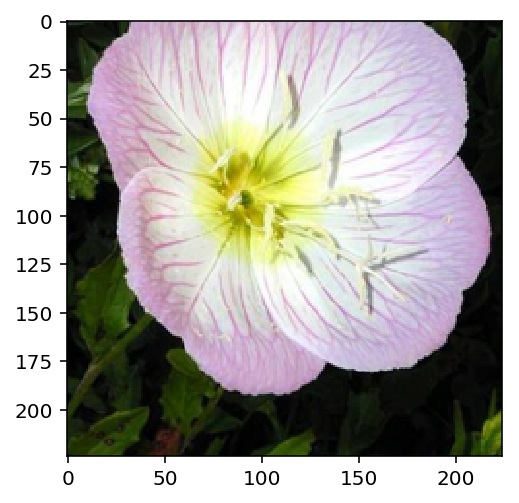

In [44]:
imshow(image_array);

It looks like I did it!

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [64]:
def predict(image_path, model, topk=5, category_names=True, gpu=True, flower_names=None):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Extract image
    image = Image.open(image_path)
    
    # Convert to tensor for PyTorch
    processed_image = process_image(image)
    tensor_image = torch.from_numpy(processed_image).float()
    
    # Format tensor for input into model
    tensor_image = tensor_image.unsqueeze(0)
    
    # Use GPU?
    if gpu:
        # Check GPU availability
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    else:
        device = "cpu"
    
    tensor_image = tensor_image.to(device)
    
    # Run image through model
    model.eval() # Put model in evaluation mode (doesn't update weights)
    model.to(device)
    output = model.forward(tensor_image)
    ps = torch.exp(output) # reverse the log conversion
    probs, classes = ps.topk(topk)
    
    # Covert to cpu
    probs = probs.cpu()
    classes = classes.cpu()
    # Convert to numpy
    probs = probs.detach().numpy()[0]
    classes = [str(i) for i in classes.numpy()[0]] # Also convert classes to str
    
    # Convert to real names
    if category_names:
        folder_convert = model.class_to_idx.items()
        flower_idx = []
        for pic_class in classes:
            for item in folder_convert:
                if str(item[1]) == pic_class:
                    flower_idx.append(item[0])
        classes = [flower_names[idx] for idx in flower_idx]
    
    return probs, classes

In [65]:
# Load saved model parameters (saved without full function)
model = models.vgg19_bn(pretrained=True)
update_classifier(model, [516, 256])
checkpoint = torch.load('checkpoint_adam.pth')
model.load_state_dict(checkpoint)
model.class_to_idx = image_datasets.train.class_to_idx

In [66]:
image_path = 'flowers/test/1/image_06743.jpg'
probs, classes = predict(image_path, model, flower_names=flower_names)
print(probs)
print(classes)

[9.9296194e-01 1.3013602e-03 1.1689462e-03 9.4246573e-04 7.7735930e-04]
['pink primrose', 'balloon flower', 'hibiscus', 'mallow', 'passion flower']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [67]:
# Test select random folder
flower_dir = "flowers/test"
random_folder = random.choice(os.listdir("flowers/test"))
random_file = random.choice(os.listdir(os.path.join(flower_dir, random_folder)))
random_file

'image_06360.jpg'

In [68]:
def select_random_image(path):
    # Select random file
    random_folder = random.choice(os.listdir(path))
    random_file = random.choice(
    os.listdir(os.path.join(path, random_folder)))

    # Create image path
    image_path = os.path.join(path, random_folder, random_file)

    return image_path

In [69]:
def display_preds(path, model, random=True, topk=5, category_names=True, gpu=True, 
                  flower_names=None):
    if random:
        # Create image path
        image_path = select_random_image(path)
        folder_number = image_path.split('\\')[1]
        title = flower_names[folder_number]
    else:
        image_path = path
        title = path.split('/')[-2]
    
    # Complete preds
    probs, classes = predict(image_path, model, topk=topk, 
                             category_names=category_names, 
                             gpu=gpu, flower_names=flower_names)
    
    fig, ax = plt.subplots(2, figsize=(4, 8))
    image = Image.open(image_path)
    image_transform = transforms.Compose(
        [transforms.Resize(256), transforms.CenterCrop(224)])
    ax[0].set_title(title)
    ax[0].imshow(image_transform(image))
    ax[0].tick_params(
        axis='both',       # Changes apply to the both axes
        which='both',      # Both major and minor ticks are affected
        bottom=False,      # Ticks along the bottom edge are off
        labelbottom=False, # Labels on the bottom edge are off
        left=False,
        labelleft=False)
    
    # Show Prediction
    ax[1].set_title('Predictions')
    ax[1].barh(classes, probs)
    ax[1].invert_yaxis()
    plt.show()

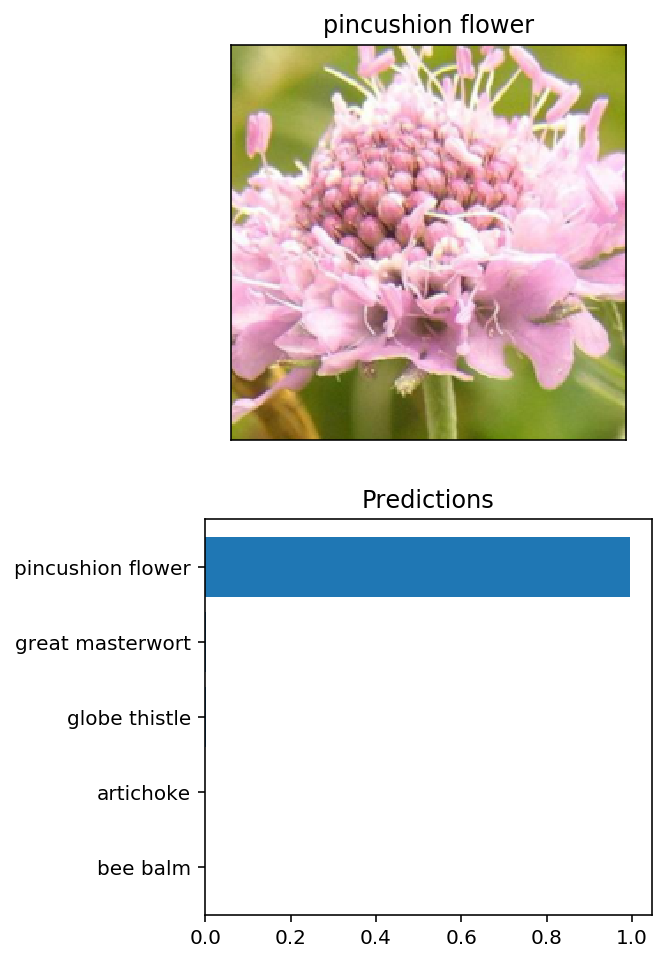

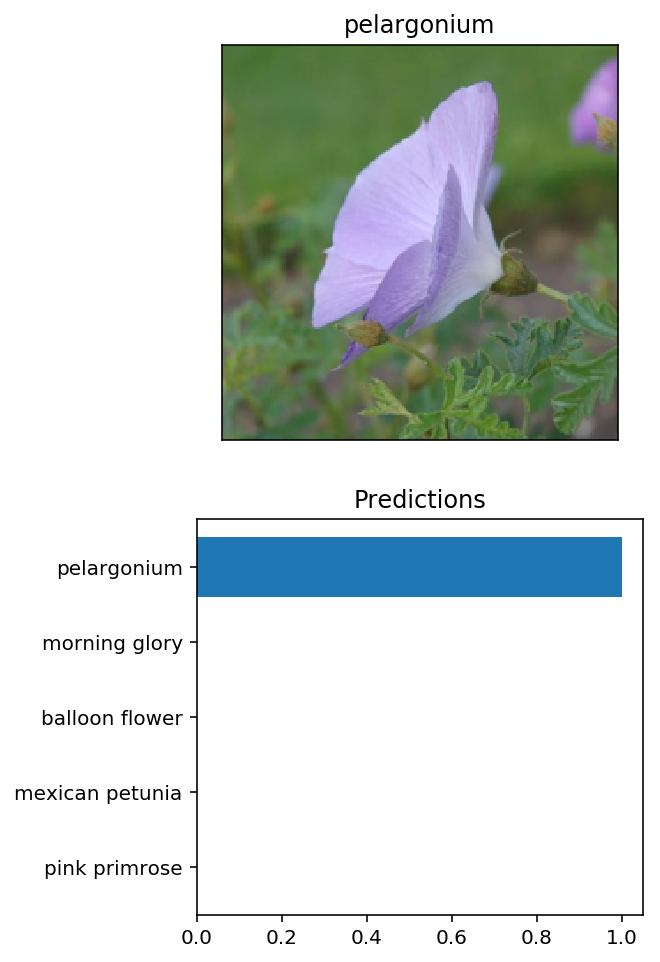

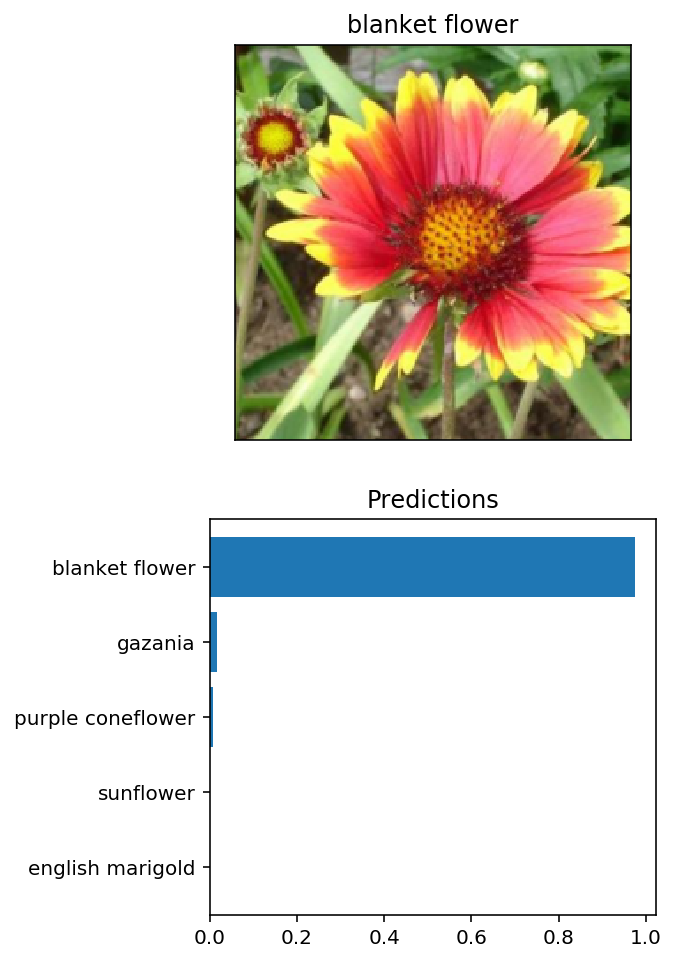

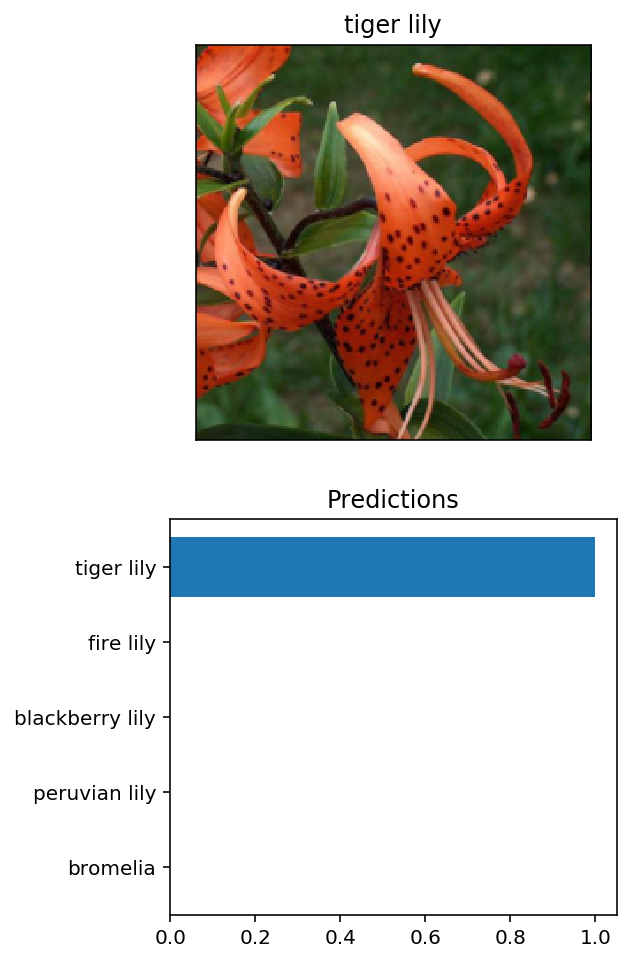

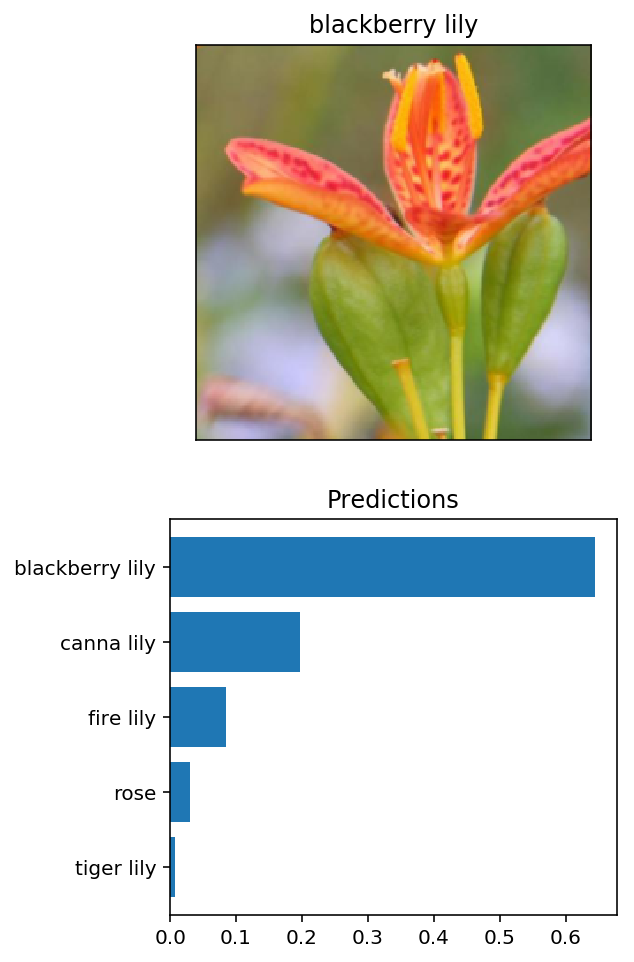

In [70]:
for i in range(5):
    display_preds('flowers/test', model, flower_names=flower_names)